[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Deep_Learning_Finanzas/blob/main/Semana02/LSTM_Bitcoin.ipynb)


# LSTM (Long-Short Term Memory)

# Descripción del problema

Datos originales: https://challengedata.ens.fr/participants/challenges/31/

El problema trata de buscar un algoritmo de clasificación que ayude a crear estrategias de inversión en criptomonedas, basado en el "sentimiento" extraído de noticias y redes sociales.

Por cada hora de trading se contabilizó la ocurrencia de algunos terminos, tales como 'adoption' y 'hack', en un selecto numero de cuentas influyentes de twitter y en algunos foros como 'Bitcointalk'.

Se han creado 10 temas diferentes, algunos positivos y otros negativos y se han contabilizado las palabras antes mencionadas, antes de una normalización.

Dado un tema y un tema, hemos visto los conteos de las últimas 48 horas y se estandarizaron esos conteos. El resultado se multiplicó por el conteo promedio por hora y se dividió por el conteo promedio por hora de todo el entrenamiento

Para un tiempo T en el periodo de tiempo i, con lag k ($k\in[\![0;47]\!]$) el valor F ode la característica será:

$$
F_{i,k}=\frac{T_{i,k}-\overline{T_{i}}}{\sqrt{\frac{1}{47}\sum\limits_{j=0}^{47}{(T_{i,j}-\overline{T_{i}})^{2}}}}*\frac{\overline{T_i}}{\overline{T}}
$$


Se agregaron 5 características correspondientes a los precios finales en periodos de 1 hr, 6 hrs, 12 hrs, 24 hrs y 48 hrs
El objetivo es predecir si el precio del Bitcoin tendrá un retorno (en la próxima hora) que sea de mas del 0.2%, entre -0.2% y 0.2% o menos al -0.2%.

La métrica utilizada para la perdida es la perdida logistica, definita como el negativo de la log-verosimilitud de las etiquetas verdaderas comparadas con las probabilidades predichas por el clasificador.

Las verdaderas etiquetas están codificadas como una matríz de 3 columnas, donde hay unos o ceros dependiendo si el elemento pertenece a la categoría de una columna u otra.

Dada una matriz P de probabilidades $p_{i,k}=Pr(t_{i,k}=1)'$ , la función de perdida se define como

$$
L_{log}(Y,P)=-log{Pr(Y|P)}=-\frac{1}{N} \sum_{i=1}^{N} \sum_{k=1}^3{y_{i,k}log(p_{i,k})}
$$

Entre más bajo el score de ésta medida, mejor.



# Dependencias

In [ ]:
# !pip install -U plotly

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers

import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Funciones

In [ ]:
def evaluate_model(estimator, train, val, test):
    print('train cross_entropy = ', estimator.evaluate(train[0], train[1], verbose = False))
    print('  val cross_entropy = ', estimator.evaluate(val[0], val[1], verbose = False))
    print(' test cross_entropy = ', estimator.evaluate(test[0], test[1], verbose = False))

In [ ]:
# TODO: Modificar para seleccionar características cambiando n_features, no sólo las primeras n_features
# TODO: Revisar los resultados generados cuando se seleccionan distintos parámetros
# NOTE: Asuma que el dataframe tiene 5 X, y 48 columnas para cada una de las 10 I ordenadas de reciente a antigua
def transform_dataframe(df, len_prices = 5, n_features = 10, len_features = 48):
    if type(len_prices) != int or type(n_features) != int or type(len_features) != int:
        raise ValueError(f'Los parámetros len_prices, n_features y len_features deben ser de tipo int. Recibibo {type(len_prices)},{type(n_features)} y {type(len_features)}')

    assert 0 < len_prices <= 5, 'len_prices debe estar entre 1 y 5'
    assert 0 < n_features <= 10, 'n_features debe estar entre 1 y 10'
    assert 0 < len_features <= 48, 'len_features debe estar entre 1 y 48'

    df.reset_index(inplace = True, drop = True)

    # Los nombres de las columnas están al reves para tener primer la observación más antigua
    prices_cols = ['X5', 'X4', 'X3', 'X2', 'X1']

    prices = np.zeros((len(df), len_prices, 1))
    features = np.zeros((len(df), len_features, n_features))

    for i in range(len(df)):
        # Se transforman la forma de los precios
        prices[i] = df.loc[i, prices_cols[-len_prices:]].values.reshape((len_prices, 1))
        # Para cada característica
        for j in range(n_features):
            # Se obtiene los 48 rezagos y se voltea el arreglo para tener el más antiguo primero
            # Aquí se aplica el supuesto de que el dataframe tiene 5 columnas de 5
            features[i, :, j] = np.flip(df.iloc[i, 5+48*j:5+len_features + 48*j].values)
    return prices, features

> The Input data contains 10 time series of 48 trading hours representing complementary features based on sentiment analysis from news extracted from twitter or forums like Bitcointalk on Bitcoin, and 5 time series based on the variation of Bitcoin price during the past 1, 6, 12, 24 and 48 hours normalised by volatility during the period. Input data, for training and testing, will be given by a .csv file, whose first line contains the header. Then each line corresponds to a sample, each column to a feature. The features are the following:

>- ***ID***: Id of the sample which is linked to the ID of the output file;
- ***I_1_lag(k)*** to ***I_10_lag(k)***: Values of Indicators *I_1* to *I_10* for each k lag ($k\in[\![0;47]\!]$) representing the normalized value of Indicators *I_1* to *I_10* each hour of the past 48 trading hours;
- ***X_1*** to ***X_5***: Values of 5 normalised indicators representing price variation of Bitcoin on the last 1, 6, 12, 24 and 48 hours.

> There will be 14 000 samples for the train set and 5 000 for the test set. For a given sample, the time series (for the 10 sentiment indicators) are given over the same 48 trading hours.

>The training outputs are given in a .csv file. Each line corresponds to a sample:

>- ***ID***: Id of the sample;
- ***Target_-1***: classification of the return of Bitcoin in the next hour. -1 signifies a down move of less than -0.2%;
- ***Target_0***: classification of the return of Bitcoin in the next hour. 0 signifies a move between -0.2% and 0.2%;
- ***Target_1***: classification of the return of Bitcoin in the next hour. 1 signifies a up move of more than 0.2%.



In [ ]:
X_raw = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana7/input_training_IrTAw7w.csv').set_index('ID')
X_raw

In [ ]:
X_raw

,X1,X2,X3,X4,X5,I1_lag0,I1_lag1,I1_lag2,I1_lag3,I1_lag4,...,I10_lag38,I10_lag39,I10_lag40,I10_lag41,I10_lag42,I10_lag43,I10_lag44,I10_lag45,I10_lag46,I10_lag47
ID,,,,,,,,,,,,,,,,,,,,,
0,0.460020,0.620360,-0.972192,2.745197,4.177783,2.325865,2.060138,0.071162,2.360597,-0.611526,...,-0.342912,-0.194165,0.122331,0.028682,-0.093626,-0.559840,0.562584,-0.557868,1.424906,-0.016294
1,-0.347872,-2.199925,-0.222026,3.741888,8.608291,-4.091293,-3.502499,-1.463631,0.383153,-3.669962,...,1.261341,-0.082428,-1.035813,-0.249607,-0.971215,-0.058408,1.460632,-0.653394,-1.743487,4.065305
2,-2.152963,-0.432461,1.619057,-0.003912,3.870262,-0.598858,-0.412391,-0.765354,-0.998152,-0.938755,...,2.245204,3.002347,2.674186,2.656251,1.062974,-0.484619,-0.044594,1.579731,0.962836,1.146983
3,-1.827669,-1.881770,-4.214322,0.178225,0.992362,0.383757,2.512478,-0.383434,-0.208506,-1.104289,...,1.383203,-1.338892,0.298076,1.808275,2.837975,2.054112,0.741138,1.701911,0.110082,0.114980
4,0.748761,1.799939,1.561006,5.204120,2.161637,-1.275226,-1.544131,-1.802590,-1.128526,-0.469835,...,-0.477313,0.742923,-0.273225,1.311015,0.744330,2.914322,1.030602,0.480722,-0.492838,1.377958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13995,-0.074522,-0.472044,-2.860659,-1.266230,-10.229167,0.583145,-0.051301,-0.584659,1.458945,2.004759,...,-1.634290,-1.527111,-1.008016,-0.500519,1.277636,1.257714,0.502732,1.751844,0.150679,-0.533808
13996,1.730118,3.177408,0.816198,1.136877,-1.588960,1.011735,-0.185748,-0.522647,2.316802,1.219339,...,-0.409750,0.840944,-1.804313,0.357944,-1.058557,-0.196874,-2.507582,0.125756,1.532976,-1.087343
13997,2.093028,4.108092,1.056253,8.163642,8.916299,2.338713,2.554397,1.665492,3.719985,-0.278893,...,-0.531223,-1.249847,-1.288419,-0.897649,-0.199824,-0.033545,0.240647,2.188396,0.039340,0.756515


In [ ]:
X_raw.loc[:,'I1_lag0':'I1_lag47']

In [ ]:
y_raw = pd.read_csv('/content/drive/MyDrive/Cruso-ApsFinancieras/semana7/output_training_F2dZW38.csv').set_index('ID')
y_raw

## División: Entrenamiento, Validación y Prueba

In [ ]:
# Division para entrenamiento de red LSTM
X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, train_size = .8, random_state = 10, shuffle = False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, train_size = .75, random_state = 10, shuffle = False)

print('     Train shape', X_train.shape)
print('Validation shape', X_val.shape)
print('      Test shape', X_test.shape)

## Transformaciones

In [ ]:
# Longitud de la serie de tiempo de variaciones de los precios del Bitcoin X_i
len_prices = 5

# Cantidad de temas vistos
n_features = 10
# Cantidad de tiempos que vemos hacia atras en las variables de sentimiento
len_features = 48

train_prices, train_features = transform_dataframe(X_train, len_prices, n_features, len_features)
val_prices, val_features     = transform_dataframe(X_val,   len_prices, n_features, len_features)
test_prices, test_features   = transform_dataframe(X_test,  len_prices, n_features, len_features)

In [ ]:
train_prices[2277]

array([[ 3.97028316],
       [ 6.7202931 ],
       [ 2.22373462],
       [ 3.23027363],
       [-0.01829927]])

In [ ]:
train_prices.shape

(8400, 5, 1)

In [ ]:
train_features[2277][:, 0]

array([ 1.92883612, -1.13139764, -2.55563541, -2.7827337 , -1.69636535,
       -0.35364418, -1.53780614,  0.69833337,  1.50214168,  0.73613771,
        2.43475398, -0.33742272, -1.49169757,  1.63658722,  3.37042789,
        2.08662641,  2.22057504,  4.35753815,  2.13720795,  0.3099949 ,
        1.97183742,  0.10596739, -0.55777435, -0.83492941,  1.99024912,
       -1.52205024,  0.89096271,  2.08234378, -2.73711221, -3.33665425,
        0.13869709, -0.49466794, -2.28211454, -0.32996602, -0.04659197,
       -1.55054048, -2.79747735,  0.31880103, -0.45138061,  0.53018201,
        2.6109897 ,  0.58643883, -0.97584244,  0.31617478, -1.87910728,
       -2.17682486,  0.01748089, -1.11954849])

In [ ]:
X_raw.loc[2277,'I1_lag0':'I1_lag47']

,2277
I1_lag0,-1.119548
I1_lag1,0.017481
I1_lag2,-2.176825
I1_lag3,-1.879107
I1_lag4,0.316175
I1_lag5,-0.975842
I1_lag6,0.586439
I1_lag7,2.610990
I1_lag8,0.530182
I1_lag9,-0.451381


In [ ]:
train_features.shape

(8400, 48, 10)

In [ ]:
print('        Labels: (samples, sequence length, features)')
print('  Train prices:', train_prices.shape)
print('Train features:', train_features.shape)

        Labels: (samples, sequence length, features)
  Train prices: (8400, 5, 1)
Train features: (8400, 48, 10)


Parentesis cultural: Revisión de dimensiones correctas

In [ ]:
np.array([1,2,3])

array([1, 2, 3])

In [ ]:
np.array([1,2,3]).shape

(3,)

In [ ]:
np.array([[1,2,3]])

array([[1, 2, 3]])

In [ ]:
np.array([[1,2,3]]).shape

(1, 3)

In [ ]:
np.array([[1],[2],[3]])

array([[1],
       [2],
       [3]])

In [ ]:
np.array([[1],[2],[3]]).shape

(3, 1)

In [ ]:
np.array([1,2,3]).reshape(-1,1)

array([[1],
       [2],
       [3]])

In [ ]:
np.array([1,2,3]).T.shape

(3,)

# Algoritmos-Modelos

## Regresión logística

El punto de referencia de los propietarios de los datos es una regresión logística tomando como características X1, $\dots$, X5.

In [ ]:
!pip show scikit-learn

Name: scikit-learn
Version: 1.6.1
Summary: A set of python modules for machine learning and data mining
Home-page: https://scikit-learn.org
Author: 
Author-email: 
License: BSD 3-Clause License

 Copyright (c) 2007-2024 The scikit-learn developers.
 All rights reserved.

 Redistribution and use in source and binary forms, with or without
 modification, are permitted provided that the following conditions are met:

 * Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

 * Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

 * Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior written permission.

 THIS SOFTWARE IS PROVIDED BY THE COPYR

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
np.set_printoptions(suppress=True)
train_prices

array([[[ 4.17778324],
        [ 2.74519725],
        [-0.97219231],
        [ 0.62035968],
        [ 0.46002033]],

       [[ 8.60829058],
        [ 3.74188805],
        [-0.22202592],
        [-2.19992478],
        [-0.34787206]],

       [[ 3.87026224],
        [-0.00391238],
        [ 1.61905739],
        [-0.43246086],
        [-2.15296262]],

       ...,

       [[-8.01161549],
        [-3.25267826],
        [-3.23511161],
        [-4.42009744],
        [-1.64528608]],

       [[-5.7431553 ],
        [-4.55756999],
        [-4.1314012 ],
        [-4.21510083],
        [ 0.26622901]],

       [[ 3.53645002],
        [ 6.40746335],
        [ 0.75612526],
        [ 1.8952313 ],
        [ 1.59236659]]])

In [ ]:
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_raw, y_raw, train_size = .8, random_state = 10, shuffle = False)

In [ ]:
X_train_0 = X_train_0[['X1', 'X2', 'X3', 'X4', 'X5']]
X_train_0

,X1,X2,X3,X4,X5
ID,,,,,
0,0.460020,0.620360,-0.972192,2.745197,4.177783
1,-0.347872,-2.199925,-0.222026,3.741888,8.608291
2,-2.152963,-0.432461,1.619057,-0.003912,3.870262
3,-1.827669,-1.881770,-4.214322,0.178225,0.992362
4,0.748761,1.799939,1.561006,5.204120,2.161637
...,...,...,...,...,...
11195,-0.197817,-0.503618,-5.999348,-7.625040,-2.796258
11196,0.511663,1.874224,0.079970,2.570751,7.507616
11197,3.405716,4.082560,5.426551,4.861720,10.263339


In [ ]:
X_test_0 = X_test_0[['X1', 'X2', 'X3', 'X4', 'X5']]
X_test_0

,X1,X2,X3,X4,X5
ID,,,,,
11200,-0.214679,3.356129,4.749172,5.709250,1.351358
11201,-1.192837,0.957475,-0.430136,-2.751596,6.960146
11202,0.450306,-0.061307,0.284349,2.194250,-3.470744
11203,0.169981,0.180298,5.055600,3.872075,7.453231
11204,0.223090,-0.213792,4.367535,4.579829,6.908846
...,...,...,...,...,...
13995,-0.074522,-0.472044,-2.860659,-1.266230,-10.229167
13996,1.730118,3.177408,0.816198,1.136877,-1.588960
13997,2.093028,4.108092,1.056253,8.163642,8.916299


In [ ]:
y_train_0

,Target -1,Target 0,Target 1
ID,,,
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
11195,1,0,0
11196,1,0,0
11197,0,1,0


In [ ]:
y_train_0 = y_train_0.idxmax(axis=1)
y_train_0

,0
ID,
0,Target 1
1,Target -1
2,Target 1
3,Target -1
4,Target 0
...,...
11195,Target -1
11196,Target -1
11197,Target 0


In [ ]:
y_test_0 = y_test_0.idxmax(axis=1)
y_test_0

,0
ID,
11200,Target 1
11201,Target 1
11202,Target 0
11203,Target 0
11204,Target 0
...,...
13995,Target 1
13996,Target 0
13997,Target 0


In [ ]:
model_0 = LogisticRegression(multi_class='multinomial', random_state=1)

In [ ]:
model_0

LogisticRegression(multi_class='multinomial', random_state=1)

In [ ]:
model_0.fit(X_train_0, y_train_0 )

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(multi_class='multinomial', random_state=1)

In [ ]:
y_pred_0 = model_0.predict(X_test_0)

In [ ]:
(y_pred_0 == y_test_0).sum() / len(y_pred_0)

0.3917857142857143

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_0, y_pred_0))

              precision    recall  f1-score   support

   Target -1       0.40      0.26      0.32       869
    Target 0       0.39      0.44      0.41       985
    Target 1       0.39      0.46      0.42       946

    accuracy                           0.39      2800
   macro avg       0.39      0.39      0.38      2800
weighted avg       0.39      0.39      0.39      2800



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

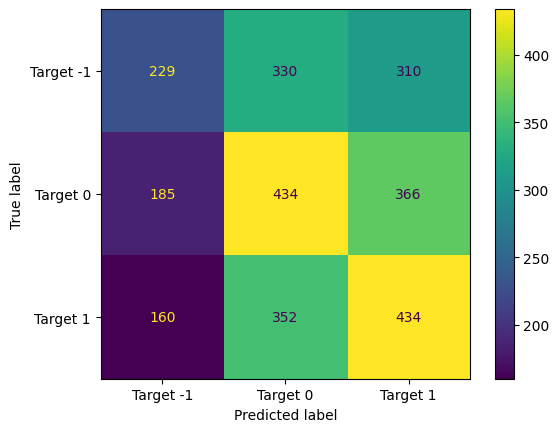

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_0, y_pred_0)

In [ ]:
from sklearn.metrics import log_loss

In [ ]:
# Otra salida útil del modelo
model_0.predict_proba(X_test_0)

array([[0.33510756, 0.36160298, 0.30328945],
       [0.32166079, 0.32059698, 0.35774222],
       [0.32411605, 0.35738386, 0.3185001 ],
       ...,
       [0.37148762, 0.34819623, 0.28031615],
       [0.34576996, 0.35426253, 0.29996751],
       [0.31150999, 0.33276448, 0.35572553]])

In [ ]:
y_test_0

,0
ID,
11200,Target 1
11201,Target 1
11202,Target 0
11203,Target 0
11204,Target 0
...,...
13995,Target 1
13996,Target 0
13997,Target 0


In [ ]:
log_loss(y_test_0, model_0.predict_proba(X_test_0))

1.0933753843632723

## Redes Neuronales

#### Callbacks

In [ ]:
# Los guarda en GoogleDrive, si no se quiere hacer la conexión, entonces cambiar la ruta o quitar el callback
# checkpoint_cb = keras.callbacks.ModelCheckpoint(
#     filepath = 'checkpoints',
#     save_best_only = True
# )

earlystop_cb = keras.callbacks.EarlyStopping(
    patience = 25,
    restore_best_weights = True
)

### Primera Aquitectura (Solo utilizando Caracteristicas de Bitcoin)

#### Aquitectura

In [ ]:
len_prices

5

In [ ]:
# Definicion de las capas
price_input = layers.Input(shape = (5, 1), name = 'price_input')
price_normalization = layers.Normalization(name = 'price_normalization', axis = 1)
price_lstm = layers.LSTM(32, name = 'price',                                                    #      <------ El 32 representa el tamaño de estado oculto
                        # kernel_regularizer=keras.regularizers.l1_l2(l1 = 1e-1, l2 = 1e-1),
                         return_sequences=True,
                         )

price_lstm2 = layers.LSTM(16, name='price2')

# Como se conectan las capas definidas arriba
price_normalized = price_normalization(price_input)
price_output = price_lstm(price_normalized)
price_output2 = price_lstm2(price_output)

# Como se conecta lo posterior
prediction_layer = keras.models.Sequential(
    [
     layers.Dense(32, activation = 'relu'),
     layers.Dense(32, activation = 'relu'),
     layers.Dense(32, activation = 'relu'),
     layers.Dense(3, activation = 'softmax')
    ],
    name = 'prediction'
)

# Como se conecta esta pequeña red extra
prediction_output = prediction_layer(price_output2)


#### Modelo

In [ ]:
# Instanciación del objeto modelo
model = keras.Model(price_input, prediction_output)

model.compile(
    loss = 'categorical_crossentropy'
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ price_input (InputLayer)             │ (None, 5, 1)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ price_normalization (Normalization)  │ (None, 5, 1)                │              11 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ price (LSTM)                         │ (None, 5, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ price2 (LSTM)                        │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ prediction (Sequential)              │ (None, 3)                   │           2,755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,254 (40.06 KB)

 Trainable params: 10,243 (40.01 KB)

 Non-trainable params: 11 (48.00 B)

In [ ]:
#Target-1   Target 0   Target 1   (yo se que la etiqueta real es Target 0)
[0.2,         0.7,      0.1]

-np.log(0.7)

0.35667494393873245

##### Visualización

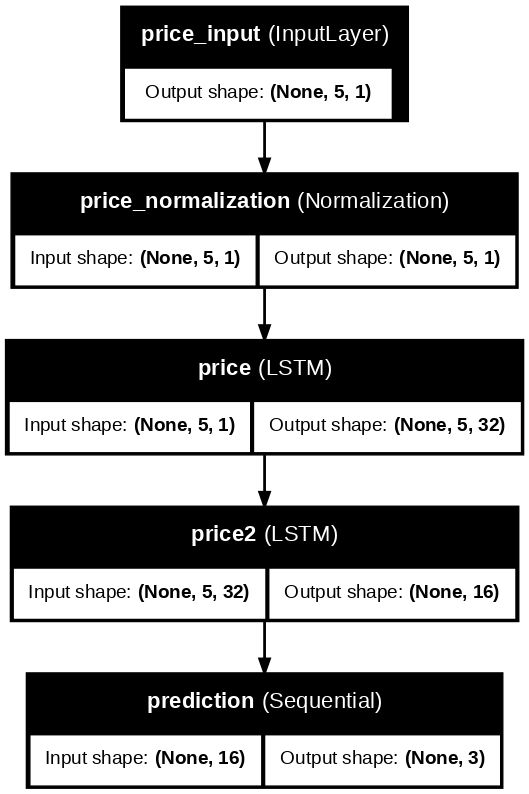

In [ ]:
# Visualización del modelo
keras.utils.plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=100,
)

#### Entrenamiento

In [ ]:
history = model.fit(
    train_prices, y_train,
    batch_size = 128,
    epochs = 1000,  # Valor real de 1000
    callbacks = [earlystop_cb],
    validation_data = [val_prices, y_val]
).history

Epoch 1/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.0980 - val_loss: 1.0920
Epoch 2/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 1.0925 - val_loss: 1.0872
Epoch 3/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.0935 - val_loss: 1.0881
Epoch 4/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0900 - val_loss: 1.0865
Epoch 5/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.0865 - val_loss: 1.0851
Epoch 6/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 1.0897 - val_loss: 1.0861
Epoch 7/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1.0908 - val_loss: 1.0837
Epoch 8/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0878 - val_loss: 1.0832
Epoch 9/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0890 - val_loss: 1.0905
Epoch 10/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0878 - val_loss: 1.0830
Epoch 11/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.0908 - val_loss: 1.0828
Epoch 12/1000
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) \
   .add_trace(go.Scatter(x = x, y = history['val_loss']))

fig.show()

#### Métricas

In [ ]:
evaluate_model(model, [train_prices, y_train], [val_prices, y_val], [test_prices, y_test])

train cross_entropy =  1.0852833986282349
  val cross_entropy =  1.082485318183899
 test cross_entropy =  1.087044358253479


In [ ]:
y_train

,Target -1,Target 0,Target 1
ID,,,
0,0,0,1
1,1,0,0
2,0,0,1
3,1,0,0
4,0,1,0
...,...,...,...
8395,0,0,1
8396,1,0,0
8397,0,0,1


In [ ]:
y_pred_prob = model.predict(test_prices)

88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
y_pred_prob

array([[0.3426666 , 0.37161875, 0.28571472],
       [0.31047425, 0.3055927 , 0.3839331 ],
       [0.3185342 , 0.39837456, 0.2830913 ],
       ...,
       [0.36580542, 0.2920916 , 0.34210294],
       [0.3694958 , 0.3054679 , 0.32503632],
       [0.2952745 , 0.4149501 , 0.2897755 ]], dtype=float32)

In [ ]:
y_pred = y_pred_prob.argmax(axis=1)
y_pred

array([1, 2, 1, ..., 0, 0, 1])

In [ ]:
y_test_f = y_test.idxmax(axis=1).map({'Target -1': 0, 'Target 0': 1, 'Target 1': 2})

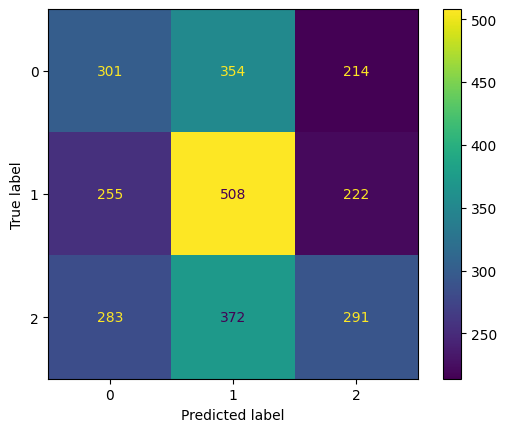

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_test_f, y_pred)

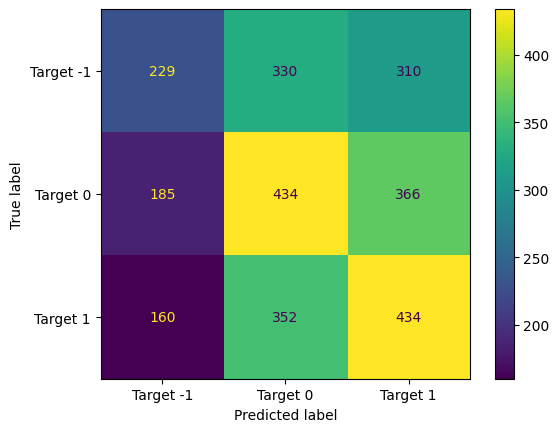

In [ ]:
# Matriz de confusión de la regresión
ConfusionMatrixDisplay.from_predictions(y_test_0, y_pred_0)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_f, y_pred))

              precision    recall  f1-score   support

           0       0.36      0.35      0.35       869
           1       0.41      0.52      0.46       985
           2       0.40      0.31      0.35       946

    accuracy                           0.39      2800
   macro avg       0.39      0.39      0.39      2800
weighted avg       0.39      0.39      0.39      2800



### Segunda Arquitectura

#### Arquitectura

In [ ]:
fusion_dim = 8

price_input = layers.Input(shape = (len_prices,), name = 'price_input')

price_layer = keras.models.Sequential(
    [
     layers.Normalization(name = 'price_normalization'),
     layers.Dense(8, activation = 'tanh'),
     layers.Dense(8, activation = 'relu'),
     layers.Dense(8, activation = 'tanh'),
     layers.Dense(fusion_dim, activation = 'relu'),
    ],
    name = 'price'
)

# CONEXIONES
price_output = price_layer(price_input)

sentiment_input = layers.Input(shape = (len_features, n_features), name = 'sentiment_input')
sentiment_normalization = layers.Normalization(name = 'sentiment_normalization', axis = 1)
sentiment_lstm = layers.LSTM(fusion_dim, name = 'sentiment')

# CONEXIONES
sentiment_normalized = sentiment_normalization(sentiment_input)
sentiment_output = sentiment_lstm(sentiment_normalized)

fusion = layers.Multiply(name = 'hadamard_product')([sentiment_output, price_output])  # "Concatenate" es otra capa

prediction_layer = keras.models.Sequential(
    [
     layers.Dense(8, activation = 'tanh'),
     layers.Dense(8, activation = 'relu'),
     layers.Dense(8, activation = 'sigmoid'),
     layers.Dense(3, activation = 'softmax')
    ],
    name = 'prediction'
)
prediction_output = prediction_layer(fusion)

#### Modelo

In [ ]:
model_2 = keras.Model([price_input, sentiment_input], prediction_output)

model_2.compile(
    loss = 'categorical_crossentropy'
)

model_2.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sentiment_input           │ (None, 48, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_normalization   │ (None, 48, 10)         │             97 │ sentiment_input[0][0]  │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_input (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment (LSTM)          │ (None, 8)              │            608 │ sentiment_normalizati… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price (Sequential)        │ (None, 8)              │            275 │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hadamard_product          │ (None, 8)              │              0 │ sentiment[0][0],       │
│ (Multiply)                │                        │                │ price[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction (Sequential)   │ (None, 3)              │            243 │ hadamard_product[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,223 (4.79 KB)

 Trainable params: 1,115 (4.36 KB)

 Non-trainable params: 108 (440.00 B)

##### Visualización

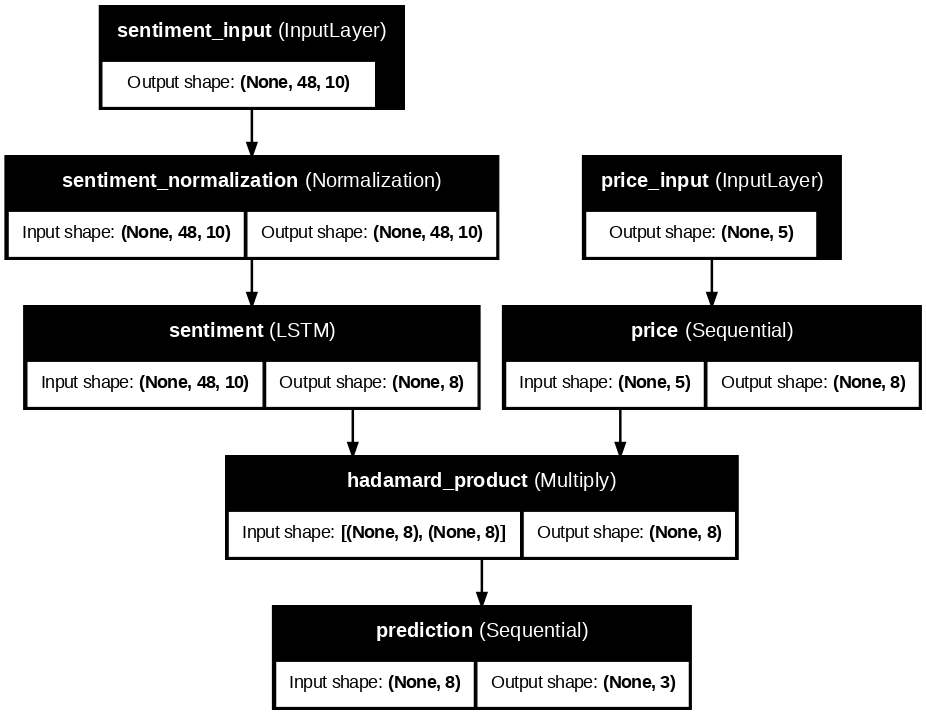

In [ ]:
keras.utils.plot_model(
    model_2,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TD",
    dpi=90,
)

#### Entrenamiento

In [ ]:
history = model_2.fit(
    [train_prices, train_features], y_train,
    epochs = 40, # Original, 1000 épocas
    callbacks = [earlystop_cb],
    validation_data = [[val_prices, val_features], y_val]
).history

Epoch 1/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - loss: 1.1498 - val_loss: 1.0998
Epoch 2/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0980 - val_loss: 1.0985
Epoch 3/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0959 - val_loss: 1.0972
Epoch 4/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.0949 - val_loss: 1.0975
Epoch 5/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0933 - val_loss: 1.0928
Epoch 6/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 1.0888 - val_loss: 1.0883
Epoch 7/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0835 - val_loss: 1.0786
Epoch 8/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0745 - val_loss: 1.0707
Epoch 9/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 1.0651 - val_loss: 1.0650
Epoch 10/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0525 - val_loss: 1.0604
Epoch 11/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.0480 - val_loss: 1.0574
Epoch 12/40
263/263 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/s

##### Visualización

In [ ]:
x = list(range(len(history['loss'])))

fig = go.Figure()

fig.add_trace(go.Scatter(x = x, y = history['loss'])) \
   .add_trace(go.Scatter(x = x, y = history['val_loss'])) \
   .update_layout(hovermode = 'x')

fig.show()

#### Métricas

In [ ]:
evaluate_model(model_2, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  0.9884680509567261
  val cross_entropy =  1.0446946620941162
 test cross_entropy =  1.047297477722168


## Guardando el mejor modelo

In [ ]:
model_2.save('best_model.keras')

# Cargar el modelo guardado

In [ ]:
best_model = keras.models.load_model('best_model.keras')
best_model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ sentiment_input           │ (None, 48, 10)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment_normalization   │ (None, 48, 10)         │             97 │ sentiment_input[0][0]  │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price_input (InputLayer)  │ (None, 5)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sentiment (LSTM)          │ (None, 8)              │            608 │ sentiment_normalizati… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ price (Sequential)        │ (None, 8)              │            275 │ price_input[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ hadamard_product          │ (None, 8)              │              0 │ sentiment[0][0],       │
│ (Multiply)                │                        │                │ price[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ prediction (Sequential)   │ (None, 3)              │            243 │ hadamard_product[0][0] │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,340 (9.15 KB)

 Trainable params: 1,115 (4.36 KB)

 Non-trainable params: 108 (440.00 B)

 Optimizer params: 1,117 (4.37 KB)

In [ ]:
evaluate_model(best_model, [[train_prices, train_features], y_train], [[val_prices, val_features], y_val], [[test_prices, test_features], y_test])

train cross_entropy =  0.9884680509567261
  val cross_entropy =  1.0446946620941162
 test cross_entropy =  1.047297477722168


# Resumen

Respecto a la segunda arquitectura:

1. Fue la que tuvo mejores resultados
2. Tardó menos épocas en entrenar



# Ejercicios

1. Crear un nuevo modelo ya sea haciendo modificaciones a alguna de las arquitecturas presentes, o comenzando desde cero. Escriba sus observaciones comparando el resultado con el mejor la Segunda Arquitectura. Como sugerencia, puede probar cambiando los datos de entrada, las capas de las redes secuenciales, la fusión de los datos, agregando regularización o dropout, callbacks, etc.
2. ¿Cómo haría la predicción para nuevos valores?

3. MAS IMPORTANTE: Cree las matrices de confusión para la última red neuronal, así como el classification report.


Parentésis cultural

In [ ]:
pd.read_csv('https://raw.githubusercontent.com/MaxMitre/Aplicaciones-Financieras/refs/heads/main/Semana4-Examen/AMF_data.csv')

,Index,Share,Day,Trader,OTR,OCR,OMR,min_time_two_events,mean_time_two_events,10_p_time_two_events,...,mean_dt_TV1_TV2,med_dt_TV1_TV2,min_dt_TV1_TV3,mean_dt_TV1_TV3,med_dt_TV1_TV3,min_dt_TV1_TV4,mean_dt_TV1_TV4,med_dt_TV1_TV4,NbSecondWithAtLeatOneTrade,type
0,1,Isin_8,Date_24,Trader_10,2.272727,8.333333,12.500000,0.0,5117.830300,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NON HFT
1,2,Isin_87,Date_29,Trader_10,1.696629,25.166667,21.571429,0.0,1846.968401,0.000074,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15,NON HFT
2,3,Isin_87,Date_23,Trader_10,1.482759,47.300000,118.250000,0.0,686.300630,0.000071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63,NON HFT
3,4,Isin_12,Date_11,Trader_10,1.705882,14.500000,29.000000,0.0,2174.335265,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NON HFT
4,5,Isin_87,Date_9,Trader_10,1.517730,26.750000,NaN,0.0,944.008551,0.000071,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38,NON HFT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54294,105778,Isin_84,Date_27,Trader_60,1.150000,23.000000,NaN,0.0,736.500080,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,NON HFT
54295,105779,Isin_102,Date_18,Trader_60,1.352941,23.000000,NaN,0.0,63.672695,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,NON HFT
54296,105780,Isin_12,Date_13,Trader_60,1.146667,86.000000,NaN,0.0,708.440816,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16,NON HFT
54297,105781,Isin_27,Date_30,Trader_60,1.179191,204.000000,NaN,0.0,384.893976,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,NON HFT
